# Imports and Installs

In [201]:
!pip install yfinance

In [202]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
gdown 5.2.0 at /usr/local/lib/python3.11/dist-packages


In [203]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
# import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
# Imports form ML (Decision Trees)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets




In [205]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/


Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=374d441f-29b3-4f98-a729-6ba792545d7e
To: /content/stocks_df_combined_2025_06_13.parquet.brotli
100% 130M/130M [00:01<00:00, 85.1MB/s]


In [206]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [207]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [208]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [209]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [210]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close_x','Volume']

In [211]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [212]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [213]:
# we define dummy variables on Dividends and Stock Splits events later, but drop the original abs. values
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Close_y','Dividends','Stock Splits'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Close_y',
 'Dividends',
 'Stock Splits',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close_x',
 'Volume']

In [214]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x+ 1e-6))

In [215]:
# define columns on Dividends or Stock Splits
df_full['div_payout'] = (df_full.Dividends>0).astype(int)
df_full['stock_split'] = (df_full['Stock Splits']>0).astype(int)

In [216]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume','div_payout','stock_split']

In [217]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [218]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [219]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [220]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [221]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [222]:
df_full.Ticker.nunique()

33

In [223]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [224]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,2000-01-03,2025-06-13,6401
ACN,2001-07-19,2025-06-13,6012
AMZN,2000-01-03,2025-06-13,6401
ASML,2000-01-03,2025-06-13,6401
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,2000-01-03,2025-06-13,6401
CDI.PA,2000-01-03,2025-06-13,6540
GOOG,2004-08-19,2025-06-13,5239


## 0.2) Dummies

In [225]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [226]:
# dummy variables are not generated from Date and numeric variables

# df.loc[:,'Month'] = df['Month'].dt.strftime('%B').astype('string')

df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')

df.loc[:,'Weekday'] = df['Weekday'].astype('string')
# .astype(str)

/tmp/ipython-input-2619569166.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.

/tmp/ipython-input-2619569166.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<StringArray>
['0', '1', '2', '3', '4', '0', '1', '2', '3', '4',
 ...
 '0', '1', '2', '3', '4', '0', '1', '2', '3', '4']
Length: 191795, dtype: string' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.



### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [227]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

/tmp/ipython-input-1081537706.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [228]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

,count
wom,
2,45083
3,44006
4,43753
1,43557
5,15396


In [229]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [230]:
# examples of encoding
df.month_wom.value_counts()[0:2]

,count
month_wom,
June_w1,3882
February_w1,3878


In [231]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [232]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [233]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [234]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 85.6 MB


In [235]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'mo

In [236]:
len(DUMMIES)

115

In [237]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [238]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 301 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(3)
memory usage: 312.4 MB


### 1.2.3) Get correlations for month_wom (month-week_of_month) with is_futur

In [239]:
DUMMIES_MONTH_WOM = [k for k in DUMMIES if k.startswith('month_wom')]
# check a few records
DUMMIES_MONTH_WOM[0:2]

['month_wom_April_w1', 'month_wom_April_w2']

In [240]:
corr_month_wom_vs_is_positive_growth_30d_future = df_with_dummies[DUMMIES_MONTH_WOM+TO_PREDICT].corr()['is_positive_growth_30d_future']

In [241]:
corr_month_wom_vs_is_positive_growth_30d_future

,is_positive_growth_30d_future
month_wom_April_w1,-0.001600
month_wom_April_w2,-0.002640
month_wom_April_w3,0.006208
month_wom_April_w4,0.004110
month_wom_April_w5,0.001731
...,...
month_wom_September_w3,-0.006012
month_wom_September_w4,0.013558
month_wom_September_w5,0.012684
growth_future_30d,0.696468


In [242]:
# create a dataframe for an easy way to sort
corr_month_wom_vs_is_positive_growth_30d_future_df = pd.DataFrame(corr_month_wom_vs_is_positive_growth_30d_future)

In [243]:
# rename column 'is_positive_growth_5d_future' to 'corr'
corr_month_wom_vs_is_positive_growth_30d_future_df.rename(columns={'is_positive_growth_30d_future':'corr'},inplace=True)

In [244]:
corr_month_wom_vs_is_positive_growth_30d_future_df.loc[:, 'abs_corr'] = corr_month_wom_vs_is_positive_growth_30d_future_df['corr'].abs()

In [245]:
corr_month_wom_vs_is_positive_growth_30d_future_df.sort_values(by='abs_corr')

,corr,abs_corr
month_wom_July_w1,-0.000010,0.000010
month_wom_March_w1,0.000244,0.000244
month_wom_May_w4,-0.000609,0.000609
month_wom_February_w5,0.001553,0.001553
month_wom_April_w1,-0.001600,0.001600
...,...,...
month_wom_November_w2,0.018822,0.018822
month_wom_November_w3,0.022097,0.022097
month_wom_October_w4,0.024968,0.024968
growth_future_30d,0.696468,0.696468


In [246]:
# ANSWER Q1 HA3: # TOP CORR NEW DUMMY with is_positive: ANSWER 0.025 (rounded to 3 digits)

### 1.2.4) Temporal split

In [247]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [248]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [249]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

,count
split,
train,0.676399
test,0.163758
validation,0.159843


In [250]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling

In [251]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 323 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(178), int64(7), object(5), string(1)
memory usage: 343.9+ MB


In [252]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,35.975752,36.358881,34.3283,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,train


In [253]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,min,max,count
split,,,
test,2021-08-20,2025-06-13,31408
train,2000-01-03,2017-10-25,129730
validation,2017-10-26,2021-08-19,30657


In [254]:
# check for imbalances of growth for train/test/validation
new_df.groupby(by='split')['growth_future_30d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,30418.0,1.019899,0.102172,0.580332,0.955986,1.016057,1.077950,1.648934
train,129730.0,1.023864,0.123190,0.246131,0.960248,1.020585,1.083310,5.179689
validation,30657.0,1.029596,0.099908,0.461847,0.973991,1.030784,1.086687,1.783610


In [255]:
new_df['is_positive_growth_30d_future'] = (new_df['growth_future_30d'] >= 1.08).astype(int)

In [256]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_30d,is_positive_growth_30d_future
3490,0.845576,0


In [257]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month_wom_October_w1,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5
3490,0.998394,0.988341,0.991494,1.372333,1.22295,2.063054,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0


## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_30d>1
* (pred2) (growth_30d>1) & (growth_snp500_30d>1)
* (pred3) (DGS10 <= 4) & (DGS5 <= 1)
* (pred4) (DGS10 > 4) & (FEDFUNDS <= 4.795)

In [258]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [259]:
# new manual predictions from HA
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [260]:
# sample of 10 observations and predictions
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds','is_positive_growth_30d_future']].sample(10)

,cci,growth_30d,growth_snp500_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_positive_growth_30d_future
818,182.602357,1.168000,1.080480,0,1,1,0,0,1
3718,144.849624,1.137278,1.026958,0,1,1,0,0,0
1688,156.491531,1.306242,1.122757,0,1,1,0,0,1
4017,-68.736754,0.982310,0.999849,0,0,0,0,0,0
5130,-89.072574,0.919032,1.003899,0,0,0,0,0,0
7428,-44.830671,1.076571,1.016163,0,1,1,1,0,1
6453,133.297269,1.056859,1.027865,0,1,1,1,0,1
1624,-111.632402,0.982928,0.999584,0,0,0,0,0,0
6274,-35.892255,1.004650,0.920233,0,1,0,0,1,1
3103,156.424666,1.051791,0.892248,0,1,0,0,0,0


In [261]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [262]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [263]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    612
1    182
Name: count, dtype: int64
is_correct_pred0
0    0.770781
1    0.229219
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    14062
1     3929
Name: count, dtype: int64
is_correct_pred1
0    0.781613
1    0.218387
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    10703
1     2664
Name: count, dtype: int64
is_correct_pred2
0    0.800703
1    0.199297
Name: count, dtype: float64
---

In [264]:
# sample of 10 predictions vs. is_correct vs. is_positive_growth_30d_future (what we're trying to predict)
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
8132,0,0,0,0,0,1,1,1,1,1,0
3015,0,1,0,1,0,1,0,1,0,1,0
1711,0,0,0,0,0,0,0,0,0,0,1
1581,0,0,0,0,0,1,1,1,1,1,0
4515,0,1,1,0,0,1,0,0,1,1,0
7445,0,0,0,0,0,1,1,1,1,1,0
1574,0,1,1,0,1,1,0,0,1,0,0
11200,0,1,1,0,0,1,0,0,1,1,0
3690,0,1,0,0,0,1,0,1,1,1,0
4392,0,1,1,1,0,1,0,0,0,1,0


In [265]:
len(new_df[new_df.split=='test'])

31408

In [266]:
# ANSWER Q2: best is pred3_manual_dgs10_5 with precision = 0.580 (rounded)

In [267]:
# pred4 seems to be empty on Test - let's check why?

# it used to be some stats
new_df[(new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)]

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4
3682,17.010899,17.547278,16.934273,16.972586,81099400.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3683,17.106682,17.394028,16.781023,17.030056,61794000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3684,17.049210,17.087522,16.244640,16.608612,58323600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3689,16.397884,16.493666,15.191030,15.440063,119759000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3690,15.899824,16.072232,15.401757,15.459227,81276600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,115.265769,115.265769,112.248964,112.965836,1009151.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1691,113.503511,115.773583,113.115213,113.981422,1117609.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1692,118.879979,118.879979,113.951538,114.847618,703080.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1693,115.893030,116.191724,113.145047,113.443741,1403644.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we utilize only Decision Tree Classifier (and not Regressor)

In [268]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [269]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [270]:
# don't use this
# def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
#   # Predict the target variable on the test data
#   y_pred = clf.predict(df_X)

#   # max_depth = clf.tree_.max_depth
#   # Print the maximum depth
#   # print("Maximum depth of the decision tree:", max_depth)

#   # # resulting df
#   # result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

#   return result_df

### 1.2.2) CLF10 (Decision Tree Classifier, max_depth==10): get unique correct predictions vs. pred0_manual...pred4_manual
* Fit(Train) on TRAIN+VALIDATION
* Predict on ALL and Join to the original new_df
* Get Precision on TEST

In [271]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')


length: X_train_valid (160387, 302),  X_test (31408, 302), all combined: X_all (191795, 302)


In [272]:
# Clean from +-inf and NaNs:

X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
# X_test = clean_dataframe_from_inf_and_nan(X_test) # won't use
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [273]:
y_train_valid = X_train_valid[to_predict]
# y_test = X_test[to_predict] # won't use
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]

In [274]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 29.9 s, sys: 194 ms, total: 30.1 s
Wall time: 33 s


In [275]:
X_train_valid.shape

(160387, 301)

In [276]:
X_all.shape

(191795, 301)

In [277]:
y_all.shape

(191795,)

In [278]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [279]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [280]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    612
1    182
Name: count, dtype: int64
is_correct_pred0
0    0.770781
1    0.229219
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    14062
1     3929
Name: count, dtype: int64
is_correct_pred1
0    0.781613
1    0.218387
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    10703
1     2664
Name: count, dtype: int64
is_correct_pred2
0    0.800703
1    0.19

In [281]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

In [282]:
# define a new column that find the cases when only pred5 is correct
new_df['only_pred5_is_correct'] = (new_df.is_correct_pred5==new_df.is_positive_growth_30d_future) & \
                         (new_df.is_positive_growth_30d_future == 1) & \
                         (new_df.is_correct_pred0 == 0) & \
                         (new_df.is_correct_pred1 == 0) & \
                         (new_df.is_correct_pred2 == 0) & \
                         (new_df.is_correct_pred3 == 0) & \
                         (new_df.is_correct_pred4 == 0)

In [283]:
# need it to be integer and not bool
new_df['only_pred5_is_correct'] = new_df['only_pred5_is_correct'].astype(int)

In [284]:
# how many times only pred5 is correct in the TEST set?
new_df[new_df.split=='test']['only_pred5_is_correct'].sum()

np.int64(483)

In [285]:
# let's look at the record
filter_unique_pred_5 = (new_df.split=='test') & (new_df.only_pred5_is_correct==1)

In [286]:
# sample with only Pred5 correct
new_df[filter_unique_pred_5].sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10,is_correct_pred5,only_pred5_is_correct
5010,2947.978157,2971.868544,2926.142483,2963.124756,1665247.0,0.0,0.0,TCS.NS,2022,October,...,0,0,0,0,0,0,0,1,1,1
5194,2114.369229,2131.071828,2102.783644,2128.561523,1689521.0,0.0,0.0,LT.NS,2023,May,...,0,0,0,0,0,0,0,1,1,1
6359,85.043143,85.965772,81.222658,83.007950,559863000.0,0.0,0.0,NVDA,2024,May,...,0,0,0,0,0,0,0,1,1,1
5590,339.762198,341.848335,335.450825,336.841583,377417.0,0.0,0.0,OR.PA,2021,September,...,0,0,0,0,0,0,0,1,1,1
5321,2998.248683,3037.471578,2997.265651,3031.426025,1801107.0,0.0,0.0,LT.NS,2023,November,...,0,0,0,0,0,0,0,1,1,1
3081,525.476042,530.253347,521.376930,527.879700,9879700.0,0.0,0.0,META,2024,August,...,0,0,0,0,0,0,0,1,1,1
7051,604.520304,612.137091,579.115049,583.405457,30954343.0,0.0,0.0,SBIN.NS,2024,January,...,0,0,0,0,0,0,0,1,1,1
3789,156.190974,160.581360,154.436794,159.947083,16683100.0,0.0,0.0,AVGO,2024,August,...,0,0,0,0,0,0,0,1,1,1
506,940.884918,942.874104,896.128236,936.309814,3835996.0,0.0,0.0,LICI.NS,2024,June,...,0,0,0,0,0,0,0,1,1,1
6277,47.463878,48.162564,47.298950,47.547840,320896000.0,0.0,0.0,NVDA,2024,January,...,0,0,0,0,0,0,0,1,1,1


In [287]:
# let's visually check that all predictions are 0, but pred5==1 (sample 10)
new_df[filter_unique_pred_5][PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,pred5_clf_10,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_correct_pred5,is_positive_growth_30d_future
6872,0,0,0,0,0,1,0,0,0,0,0,1,1
6422,0,0,0,0,0,1,0,0,0,0,0,1,1
6937,0,0,0,0,0,1,0,0,0,0,0,1,1
13091,0,0,0,0,0,1,0,0,0,0,0,1,1
3716,0,0,0,0,0,1,0,0,0,0,0,1,1
5001,0,0,0,0,0,1,0,0,0,0,0,1,1
6207,0,0,0,0,0,1,0,0,0,0,0,1,1
6192,0,0,0,0,0,1,0,0,0,0,0,1,1
13088,0,0,0,0,0,1,0,0,0,0,0,1,1
6025,0,0,0,0,0,1,0,0,0,0,0,1,1


In [288]:
# ANSWER HA3: 3659 unique correct prediction from clf_10 (on test)

## 1.2.3 [Code Snippet 2] Hyperparams tuning for a Decision Tree Classifier

In [289]:
# TODO HA: Define DUMMIES_SHORT to include only original dummies (and exclude too detailed dummies like month_week_of_month, let's leave only month) --> less features

In [290]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (129730, 302),  X_validation (30657, 302), X_test (31408, 302), X_train_valid = (160387, 302),  all combined: X_all (191795, 302)


In [291]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)

X_test = clean_dataframe_from_inf_and_nan(X_test)

X_all = clean_dataframe_from_inf_and_nan(X_all)

In [292]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

In [293]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text


In [294]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [295]:
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [296]:
# pre-calculated results
precision_by_depth = {1: 0.5466, 2: 0.5511, 3: 0.5511, 4: 0.5511, 5: 0.6278, 6: 0.5691, 7: 0.5945, 8: 0.5891, 9: 0.5912, 10: 0.5888, 11: 0.5916, 12: 0.5855, 13: 0.5822, 14: 0.592, 15: 0.5833, 16: 0.5898, 17: 0.586, 18: 0.5861, 19: 0.5869, 20: 0.5773}




In [297]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 65],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [298]:
%%time
clf_5, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=5)


# predict on a full dataset
y_pred_all = clf_5.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_5'] = y_pred_all

CPU times: user 15.3 s, sys: 263 ms, total: 15.5 s
Wall time: 15.5 s


In [299]:
# MANUAL SECOND BEST, need some complexity
# found earlier in HyperParams Tuning
best_depth = 14
best_precision = precision_by_depth[best_depth]

In [300]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 14, precision (on test)=0.592


In [301]:
%%time
clf_best, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 38.1 s, sys: 157 ms, total: 38.3 s
Wall time: 38.8 s


In [302]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 5241
Number of leaves: 2621


In [303]:
clf_best

DecisionTreeClassifier(max_depth=14, random_state=42)

In [304]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [305]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred7_clf_second_best'] = y_pred_clf_best

In [306]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    612
1    182
Name: count, dtype: int64
is_correct_pred0
0    0.770781
1    0.229219
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    14062
1     3929
Name: count, dtype: int64
is_correct_pred1
0    0.781613
1    0.218387
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    107

### 1.2.4) Two ways of visualisation

In [307]:
# train a simple tree
%%time
clf_2,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=2)

CPU times: user 6.39 s, sys: 121 ms, total: 6.51 s
Wall time: 6.53 s


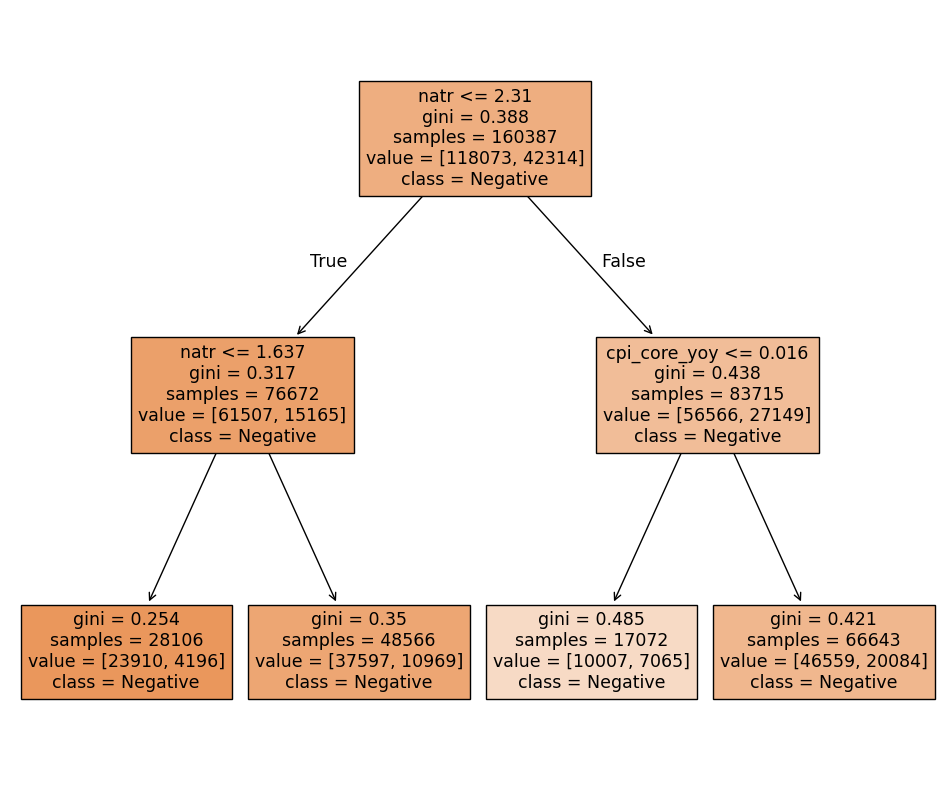

In [308]:
# Visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf_2 is your trained DecisionTreeClassifier
plt.figure(figsize=(12,10))  # Set the size of the figure
plot_tree(clf_2,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [309]:
  tree_rules = export_text(clf_2, feature_names=list(X_train), max_depth=1)
  print(tree_rules)

|--- natr <= 2.31
|   |--- natr <= 1.64
|   |   |--- class: 0
|   |--- natr >  1.64
|   |   |--- class: 0
|--- natr >  2.31
|   |--- cpi_core_yoy <= 0.02
|   |   |--- class: 0
|   |--- cpi_core_yoy >  0.02
|   |   |--- class: 0



## 1.3) [Code Snippet 3] Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [310]:
from sklearn.ensemble import RandomForestClassifier
import time

# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again

In [311]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [5, 7, 9, 11, 13, 15, 17, 19]:
#   for estimators in [10,50,100,200]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [312]:
# uncomment when you run the hyperparam tuning again
# print(precision_matrix)

In [313]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest
best_precision_matrix_random_forest = best_precision_matrix_random_forest = {
    (5, 10): 0.5498,
    (5, 50): 0.5511,
    (5, 100): 0.5511,
    (5, 200): 0.5511,
    (7, 10): 0.5540,
    (7, 50): 0.5492,
    (7, 100): 0.5495,
    (7, 200): 0.5515,
    (9, 10): 0.5411,
    (9, 50): 0.5461,
    (9, 100): 0.5507,
    (9, 200): 0.5517,
    (11, 10): 0.5623,
    (11, 50): 0.5559,
    (11, 100): 0.5565,
    (11, 200): 0.5521,
    (13, 10): 0.5510,
    (13, 50): 0.5591,
    (13, 100): 0.5614,
    (13, 200): 0.5575,
    (15, 10): 0.5596,
    (15, 50): 0.5592,
    (15, 100): 0.5585,
    (15, 200): 0.5505,
    (17, 10): 0.5538,
    (17, 50): 0.5543,
    (17, 100): 0.5510,
    (17, 200): 0.5493,
    (19, 10): 0.5611,
    (19, 50): 0.5559,
    (19, 100): 0.5599,
    (19, 200): 0.5544,
}

In [314]:
# # Define the precision_matrix from the long calculation above
# best_precision_matrix = {
#      (5, 10): 0.5498, (5, 20): 0.5506,
#      (5, 50): 0.5511, (5, 100): 0.5511,
#      (6, 10): 0.5555, (6, 20): 0.551,
#      (6, 50): 0.5498, (6, 100): 0.5509,
#      (7, 10): 0.554, (7, 20): 0.5478,
#      (7, 50): 0.5492, (7, 100): 0.5495,
#      (8, 10): 0.5475, (8, 20): 0.5425,
#      (8, 50): 0.5516, (8, 100): 0.5507}


In [315]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[5, 20])

# Show the figure
fig.show()

In [316]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 50
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 19

In [317]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 2min 5s, sys: 455 ms, total: 2min 6s
Wall time: 1min 14s


## 1.4) [Code Snippet 1] Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many cases when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [318]:
from sklearn.linear_model import LogisticRegression

In [319]:
# Large feature magnitudes can cause convergence issues. If you haven’t already, scale your data:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [320]:
# UNCOMMENT TO RUN IT AGAIN

# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#     # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',  # 'sag' - another option
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [321]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [322]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5459, (1, 100): 0.5367, (1, 200): 0.5277, (0.1, 50): 0.5466, (0.1, 100): 0.5373, (0.1, 200): 0.5285, (0.01, 50): 0.5476, (0.01, 100): 0.5428, (0.01, 200): 0.54}


In [323]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5459)

In [324]:
# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) [Code Snippet 4 - ADVANCED] Neural Network (NN) and HyperParams tuning
* [Tutorial from Tensorflow.org](https://www.tensorflow.org/tutorials/keras/classification)
* [TowardsDataScience Hyperparameter Optimization with Keras](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)
* [Machine Learning Mastery tutorial with Keras Deep Learning](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [325]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [326]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 301}

In [327]:
# you need to install TF if using a v28 machine
# !pip install tensorflow

In [328]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [329]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [330]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 301}

In [331]:

model = build_model(nn_params)
model.summary()
# model.get_config()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,361 (560.00 KB)

 Trainable params: 143,361 (560.00 KB)

 Non-trainable params: 0 (0.00 B)

In [332]:
# trainable params in the model with max params (largest hidden layers size)
model.count_params()

143361

In [333]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [334]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [335]:
# UNCOMMENT TO RUN IT
# # returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [336]:
# UNCOMMENT WHEN RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [337]:
# best_model_nn.summary()

In [338]:
# check the best history of training
# best_history

In [339]:
# pre computed history
best_history_nn ={'accuracy': [0.6206425428390503,
  0.6563935875892639,
  0.6715070605278015,
  0.6781659126281738,
  0.6846689581871033,
  0.6899000406265259,
  0.6924314498901367,
  0.6940774321556091,
  0.6963594555854797,
  0.6981488466262817,
  0.6982797980308533,
  0.7005742192268372],
 'loss': [0.6485477089881897,
  0.6164013743400574,
  0.6015466451644897,
  0.5939826965332031,
  0.5864177346229553,
  0.5822728872299194,
  0.5788451433181763,
  0.5766140818595886,
  0.5728825926780701,
  0.5714946389198303,
  0.5709761381149292,
  0.5681091547012329],
 'precision_1': [0.6281318068504333,
  0.6705082058906555,
  0.6927300691604614,
  0.7030346393585205,
  0.7096523642539978,
  0.7157368659973145,
  0.7195449471473694,
  0.7237764596939087,
  0.724949061870575,
  0.7277039289474487,
  0.7285037040710449,
  0.7305046916007996],
 'val_accuracy': [0.5095517039299011,
  0.5176388025283813,
  0.5059220790863037,
  0.49360036849975586,
  0.4926133453845978,
  0.4922631084918976,
  0.49605196714401245,
  0.48605450987815857,
  0.48605450987815857,
  0.4821383059024811,
  0.47784003615379333,
  0.4782857894897461],
 'val_loss': [0.7736297845840454,
  0.9822676181793213,
  1.0234887599945068,
  1.1025390625,
  1.1842303276062012,
  1.1674247980117798,
  1.1660196781158447,
  1.2397290468215942,
  1.2409558296203613,
  1.2863727807998657,
  1.3408353328704834,
  1.328245759010315],
 'val_precision_1': [0.5571497082710266,
  0.5591427087783813,
  0.5572323799133301,
  0.5471343398094177,
  0.5460649728775024,
  0.546144962310791,
  0.5497111082077026,
  0.5439006090164185,
  0.5426294207572937,
  0.5389731526374817,
  0.5362157225608826,
  0.5376880168914795]}

In [340]:
X_train_valid.shape

(160387, 301)

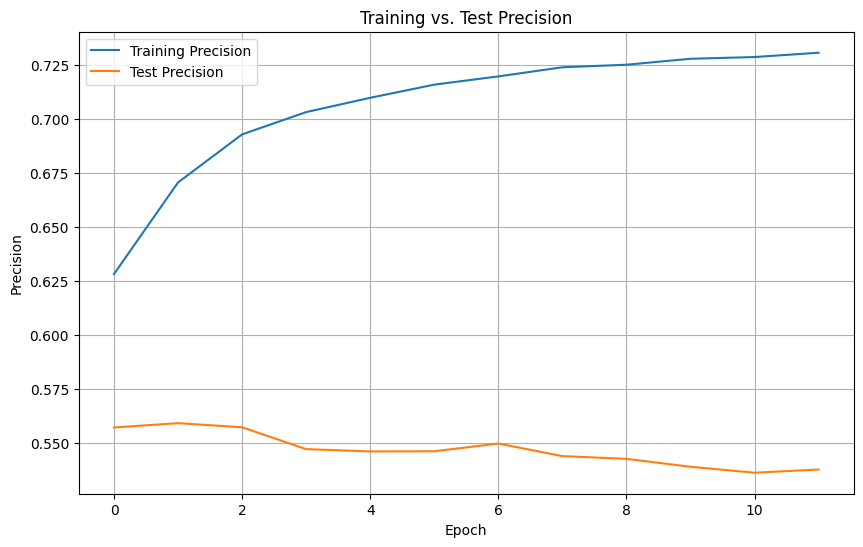

In [341]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_1'], label='Training Precision')
plt.plot(best_history_nn['val_precision_1'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) [Code Snippet 5] Different Decision rules to improve the Precision (varying Threshold)
* best model1 **(clf_best)**: Decision Tree (max_depth=15)
* best model2 **(rf_best)**: Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [342]:
# predicting probability instead of a label
y_pred_test = clf_best.predict_proba(X_test)

# y_pred_test = rf_best.predict_proba(X_test)

y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [343]:
# example prediction
y_pred_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [344]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])

# sample of predictions
y_pred_test_class1_df.sample(10)

,Class1_probability
1120,0.0
7440,0.0
26741,0.0
17138,0.0
27116,0.0
25382,0.0
1803,0.0
28986,0.0
15818,0.0
24285,0.0


In [345]:
# Mean prediction is 0.3, median is 0.0, 75% quantile is 0.9
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,31408.0,0.172617,0.377786,0.0,0.0,0.0,0.0,1.0


In [346]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

np.float64(0.23595899133978604)

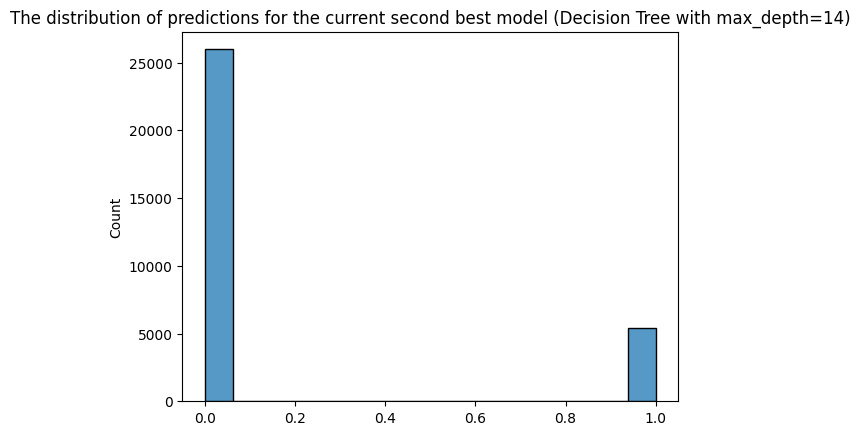

In [347]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title(f'The distribution of predictions for the current second best model (Decision Tree with max_depth={clf_best.get_depth()})')

# Show the plot
plt.show()

In [348]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [349]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [350]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,7411,23997,0,0,0.235959,1.000000,0.235959,0.381823,1.000000,1.000000
1,0.02,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
2,0.04,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
3,0.06,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
4,0.08,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
5,0.10,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
6,0.12,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
7,0.14,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
8,0.16,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564
9,0.18,1213,4213,6198,19784,0.223553,0.163676,0.668524,0.188985,0.163676,0.175564


In [351]:
df_scores[(df_scores.threshold>=0.6) & (df_scores.threshold<=0.92)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
30,0.60,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
31,0.62,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
32,0.64,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
33,0.66,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
34,0.68,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
35,0.70,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
36,0.72,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
37,0.74,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
38,0.76,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439
39,0.78,1213,4210,6198,19787,0.223677,0.163676,0.668619,0.189029,0.163676,0.175439


In [352]:
# TODO: HA to build a similar dataframe for random_forest and find optimal thresholds

<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

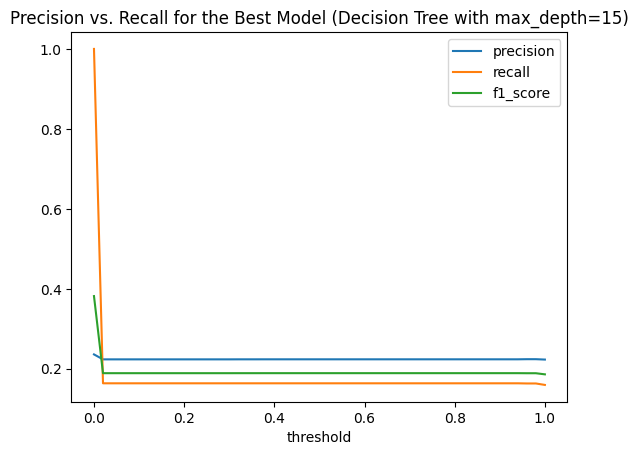

In [353]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [354]:
# existing predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best']

In [355]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.84).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.92).astype(int)


In [356]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=19, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [357]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


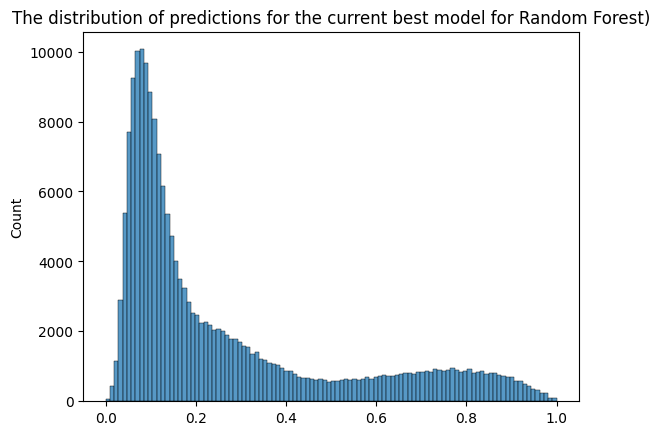

In [358]:
# PREDICTIONS ON A FULL DATASET - more smooth dataset - good sign
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()

In [359]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.60 and 0.70
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

<Axes: >

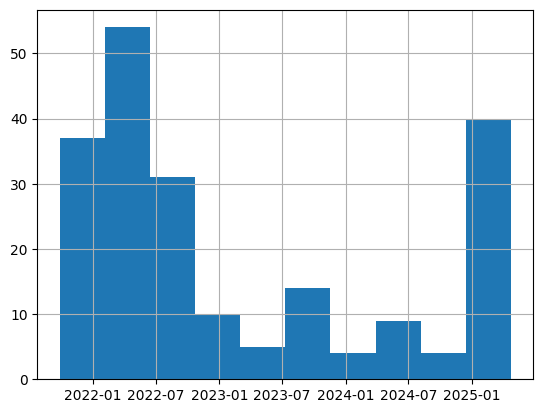

In [360]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

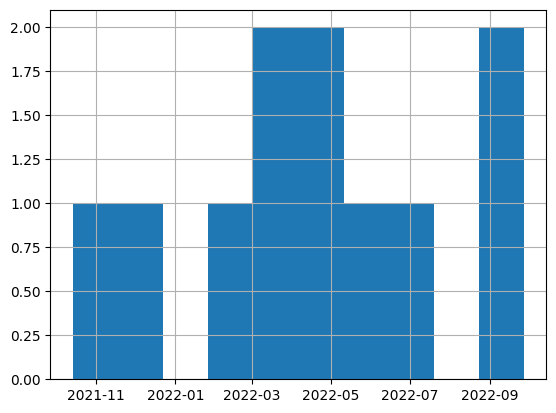

In [361]:
# When did it predict to trade for the "rare" positive prediction pred10?
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()

In [362]:
# sample of rare predictions with high threshold
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,is_correct_pred6,is_correct_pred7,proba_pred8,pred8_clf_second_best_rule_84,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65
2538,165.151644,166.973061,155.238373,156.313309,50724900.0,0.0,0.0,META,2022,June,...,1,1,0.248299,0,0.248299,0,0.698528,1,0.698528,1
2501,173.611738,180.359947,168.207218,174.129303,71062900.0,0.0,0.0,META,2022,April,...,1,0,1.000000,1,1.000000,1,0.672570,1,0.672570,1
6590,1878.351882,1919.524560,1865.918799,1910.773560,2879079.0,0.0,0.0,HINDUNILVR.NS,2022,March,...,1,0,0.607143,0,0.607143,0,0.675261,1,0.675261,1
2606,137.273023,138.765987,133.490846,133.769531,30826500.0,0.0,0.0,META,2022,September,...,1,0,1.000000,1,1.000000,1,0.657182,1,0.657182,1
2605,139.462710,141.572776,135.551153,135.730301,30497000.0,0.0,0.0,META,2022,September,...,1,0,1.000000,1,1.000000,1,0.678436,1,0.678436,1
6290,102.750000,110.780502,102.405502,106.930496,132026000.0,0.0,0.0,AMZN,2022,May,...,1,0,1.000000,1,1.000000,1,0.675233,1,0.675233,1
6491,2515.866979,2544.383465,2490.439779,2518.528564,2158809.0,0.0,0.0,HINDUNILVR.NS,2021,October,...,1,1,0.128960,0,0.128960,0,0.653105,1,0.653105,1
6527,2217.153135,2242.210529,2217.153135,2238.528564,839769.0,0.0,0.0,HINDUNILVR.NS,2021,December,...,1,1,0.128960,0,0.128960,0,0.655921,1,0.655921,1
6286,114.849998,119.050499,113.081497,114.772499,124260000.0,0.0,0.0,AMZN,2022,May,...,1,1,0.000000,0,0.000000,0,0.652855,1,0.652855,1
2450,227.388334,229.339132,217.743786,218.520126,46156900.0,0.0,0.0,META,2022,February,...,1,1,0.000000,0,0.000000,0,0.655314,1,0.655314,1


In [363]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [364]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())

In [365]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())

In [366]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

991

In [367]:
pred10_daily_positive_count

,pred11_rf_best_rule_65
Date,
2021-10-14,1
2021-12-08,1
2022-02-11,1
2022-03-09,1
2022-03-14,1
2022-04-27,1
2022-05-06,1
2022-05-12,1
2022-06-21,1


array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

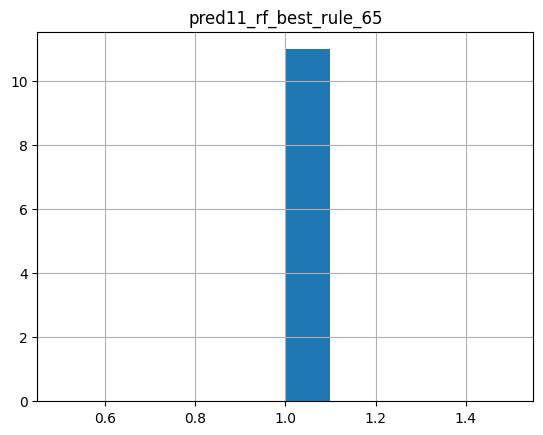

In [368]:
pred10_daily_positive_count.hist()

In [369]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred11_rf_best_rule_65,11.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


array([[<Axes: title={'center': 'pred10_rf_best_rule_55'}>]], dtype=object)

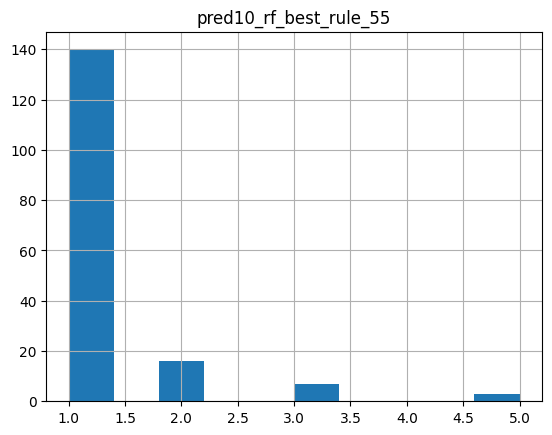

In [370]:
pred9_daily_positive_count.hist()

In [371]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_55,166.0,1.253012,0.702263,1.0,1.0,1.0,1.0,5.0


## 2.3) Agg. stats on ALL predictions

In [372]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    612
1    182
Name: count, dtype: int64
is_correct_pred0
0    0.770781
1    0.229219
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    14062
1     3929
Name: count, dtype:

In [373]:
# check approx. periods : Train is 2000-01...2017-01, Valid is 2017-01..2020-09, Test is 2020-09..2024-05
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2021-08-20,2025-06-13
train,2000-01-03,2017-10-25
validation,2017-10-26,2021-08-19


In [374]:
# GET PREDICTION NUMBER: Easier solution not using regular expressions

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [375]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [376]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [377]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [378]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum     6403.000000   17976.000000   4713.000000
                              mean       0.203865       0.138565      0.153733
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum     1218.000000    4452.000000   1938.000000
                              mean       0.038780       0.034317      0.063216
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum     7926.000000   24182.000000   6200.000000
                              mean       0.252356       0.186403      0.202238
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum     5103.000000   15987.000000   4139.000000
                              mean       0.162475       0.123233      0.135010
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum     4799.000000   14025.000000   3347.000000
                              mean       0.152795       0.108109      0.109176
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum      208.000000   26316.000000   6675.000000
                              mean       0.006623       0.202852      0.217732
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum       11.000000   20597.000000   5265.000000
                              mean       0.000350       0.158768      0.171739

In [379]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred0_manual_cci              count  31408.000000  129730.000000  30657.000000
                              sum      794.000000    3428.000000    886.000000
                              mean       0.025280       0.026424      0.028900
pred1_manual_prev_g1          count  31408.000000  129730.000000  30657.000000
                              sum    17991.000000   76372.000000  19721.000000
                              mean       0.572816       0.588700      0.643279
pred2_manual_prev_g1_and_snp  count  31408.000000  129730.000000  30657.000000
                              sum    13367.000000   57404.000000  16695.000000
                              mean       0.425592       0.442488      0.544574
pred3_manual_dgs10_5          count  31408.000000  129730.000000  30657.000000
                              sum      997.000000   13333.000000  11908.000000
                              mean       0.031744       0.102775      0.388427
pred4_manual_dgs10_fedfunds   count  31408.000000  129730.000000  30657.000000
                              sum     5660.000000   30611.000000      0.000000
                              mean       0.180209       0.235959      0.000000
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum     6403.000000   17976.000000   4713.000000
                              mean       0.203865       0.138565      0.153733
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum     1218.000000    4452.000000   1938.000000
                              mean       0.038780       0.034317      0.063216
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum     7926.000000   24182.000000   6200.000000
                              mean       0.252356       0.186403      0.202238
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum     5103.000000   15987.000000   4139.000000
                              mean       0.162475       0.123233      0.135010
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum     4799.000000   14025.000000   3347.000000
                              mean       0.152795       0.108109      0.109176
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum      208.000000   26316.000000   6675.000000
                              mean       0.006623       0.202852      0.217732
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum       11.000000   20597.000000   5265.000000
                              mean       0.000350       0.158768      0.171739

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_pred10"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

### [Code Snippet 7] 3.1.1 Calculate fin. result from simulations for one predictor 'pred6_clf_best'

In [380]:
# current prediction
pred = 'pred6_clf_5'

In [381]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close_x.count()

np.int64(31408)

In [382]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

991

In [383]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [384]:
# SAMPLE: compare the predictions from pred6_clf_best to real is_positive_growth_30d_future
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(10)

,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5
1503,1.171637,1,0
3804,1.027725,0,0
3531,1.146754,1,0
1180,1.199275,1,1
5162,0.980928,0,0
4557,1.167836,1,0
2285,1.201014,1,0
10545,1.019038,0,0
8743,0.989541,0,0
3317,0.812585,0,0


In [385]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)

In [386]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [387]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [388]:
# sample results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(10)

,Date,Ticker,Close_x,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
3649,2024-07-22,IDEXY,24.415768,1.081114,1,1,8.111379,-0.2,7.911379
6242,2025-01-22,IBN,27.549999,1.013430,0,1,1.343016,-0.2,1.143016
5935,2023-10-30,IBN,22.348427,1.085182,1,1,8.518187,-0.2,8.318187
5904,2023-09-15,IBN,23.686953,0.924655,0,1,-7.534529,-0.2,-7.734529
6961,2023-09-11,ITC.NS,418.604309,0.971266,0,1,-2.873442,-0.2,-3.073442
6021,2024-03-05,IBN,26.046724,0.975638,0,1,-2.436243,-0.2,-2.636243
7022,2023-12-12,RELIANCE.NS,1207.925293,1.116375,1,1,11.637547,-0.2,11.437547
5878,2023-08-09,IBN,23.439077,0.962775,0,1,-3.722503,-0.2,-3.922503
6868,2023-04-28,RELIANCE.NS,1113.281860,1.026296,0,1,2.629626,-0.2,2.429626
6252,2025-02-05,IBN,29.180000,1.050034,0,1,5.003424,-0.2,4.803424


In [389]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

3.0


In [390]:
# how many times do we invest daily (a lot)
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_5,544.0,2.238971,1.365811,1.0,1.0,2.0,3.0,6.0


In [391]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

,0
sim1_gross_rev_pred6,2269.455003
sim1_fees_pred6,-243.600000
sim1_net_rev_pred6,2025.855003


### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [392]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 (trading) days  in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 794 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    1613.043262
sim1_fees_pred0         -158.800000
sim1_net_rev_pred0      1459.643262
dtype: float64
        Count Investments in 4 years (on TEST): 794
        Gross Revenue: $1613
        Fees (0.2% for buy+sell): $158
        Net Revenue: $1459
        Fees are 9 % from Gross Revenue
        Capital Required : $6000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $7459 (Vfinal)
        Average CAGR on TEST (4 years) : 1.056, or 5.6% 
        Average daily stats: 
            Average net revenue per investment: $1.84 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17991 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    29618

In [393]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [394]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,794,1613.043262,-158.8,1459.643262,0.098447,1.838342,1.850816,6000.0,1.055946,1.243274
1,pred1_manual_prev_g1,17991,29618.243475,-3598.2,26167.843475,0.121486,1.454496,18.154390,75000.0,1.077694,1.348905
2,pred2_manual_prev_g1_and_snp,13367,17019.666162,-2673.4,14475.066162,0.157077,1.082896,22.967354,81000.0,1.041960,1.178705
3,pred3_manual_dgs10_5,997,2845.843984,-199.4,2646.443984,0.070067,2.654407,31.156250,96000.0,1.006822,1.027567
4,pred4_manual_dgs10_fedfunds,5660,8594.814190,-1132.0,7660.814190,0.131707,1.353501,31.620112,99000.0,1.018808,1.077382
5,pred5_clf_10,6403,18623.318706,-1280.6,17401.118706,0.068763,2.717651,6.732913,30000.0,1.121158,1.580037
6,pred6_clf_5,1218,2269.455003,-243.6,2025.855003,0.107339,1.663264,2.238971,9000.0,1.052065,1.225095
7,pred7_clf_second_best,7926,14008.203189,-1585.2,12470.803189,0.113162,1.573404,8.137577,36000.0,1.077195,1.346411
8,pred8_clf_second_best_rule_84,5103,7358.587115,-1020.6,6382.787115,0.138695,1.250791,5.343455,24000.0,1.060728,1.265949
9,pred9_clf_second_best_rule_92,4799,7453.713073,-959.8,6531.713073,0.128768,1.361057,5.216304,24000.0,1.062026,1.272155


In [395]:

# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'},
    height=600  # <- Increase height here

)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [396]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
9,pred9_clf_second_best_rule_92,4799,7453.713073,-959.8,6531.713073,0.128768,1.361057,5.216304,24000.0,1.062026,1.272155


In [397]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84','pred7_clf_second_best'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
7,pred7_clf_second_best,7926,14008.203189,-1585.2,12470.803189,0.113162,1.573404,8.137577,36000.0,1.077195,1.346411
8,pred8_clf_second_best_rule_84,5103,7358.587115,-1020.6,6382.787115,0.138695,1.250791,5.343455,24000.0,1.060728,1.265949
